# **ABCDEats Inc. - Clustering Analysis**

# 1. Imports, Options and Ingestion

In [236]:
# Imports list
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA, FactorAnalysis

from sklearn.model_selection import train_test_split

from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

In [156]:
# Style is importantuntitled:Untitled-1.ipynb?jupyter-notebook
sns.set(style="white")

# Ensuring pandas always prints all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)

%config InlineBackend.figure_format = 'retina'

In [157]:
# Reading the csv data

data = pd.read_csv('/home/shadybea/OneDrive/General/Data Mining/Project/DM2425_ABCDEats_DATASET.csv')

# 2. Initial Transformations

In [158]:
_rename_dict = {
        'customer_region' : 'cust_region'
        , 'payment_method' : 'pay_method'
        , 'customer_age' : 'cust_age'
        , 'vendor_count' : 'n_vendor'
        , 'product_count' : 'n_product'
        , 'n_order' : 'n_order'
        , 'is_chain' : 'n_chain'
        , 'CUI_American' : 'american'
        , 'CUI_Asian' : 'asian'
        , 'CUI_Beverages' : 'beverages'
        , 'CUI_Cafe' : 'cafe'
        , 'CUI_Chicken Dishes' : 'chicken_dishes'
        , 'CUI_Chinese' : 'chinese'
        , 'CUI_Desserts' : 'desserts'
        , 'CUI_Healthy' : 'healthy'
        , 'CUI_Indian' : 'indian'
        , 'CUI_Italian' : 'italian'
        , 'CUI_Japanese' : 'japanese'
        , 'CUI_Noodle Dishes' : 'noodle_dishes'
        , 'CUI_OTHER' : 'other'
        , 'CUI_Street Food / Snacks' : 'street_food_snacks'
        , 'CUI_Thai' : 'thai'
}

# Rename the columns for easier reference
data.rename(columns=_rename_dict, inplace=True)

In [159]:
# Make the integer value of the customer hex values, the index. 
data['customer_id'] = data['customer_id'].apply(lambda x: int(x, 16))

# Set 'customer_id' as the index
data = data[~data['customer_id'].duplicated()].set_index('customer_id')

## 2.1. Missing Values

In [160]:
# Fill missing values for first_order
data.loc[data['first_order'].isna(), 'first_order'] = 0

In [161]:
# Fill missing values for HR_0
sum_week = data[[f"DOW_{n}" for n in range(7)]].sum(axis=1)
sum_day = data[[f"HR_{n}" for n in range(24)]].sum(axis=1)

data.loc[data['HR_0'].isna(), 'HR_0'] = (sum_week - sum_day)

In [162]:
# Fill missing values for cust_age
# TODO

## 2.2. Inconsistencies

### 2.2.1. Duplicate Values

In [163]:
len(data[data.duplicated(keep=False)])

94

In [164]:
len(data[data.duplicated()])

47

In [165]:
data[data.duplicated(keep=False)].head()

,cust_region,cust_age,n_vendor,n_product,n_chain,first_order,last_order,last_promo,pay_method,american,asian,beverages,cafe,chicken_dishes,chinese,desserts,healthy,indian,italian,japanese,noodle_dishes,other,street_food_snacks,thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
279920249645,2360,24.0,1,2,0,0.0,11,DELIVERY,DIGI,0.00,0.0,0.0,0.0,0.0,10.36,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
288674416441,2360,24.0,1,2,0,0.0,11,DELIVERY,DIGI,0.00,0.0,0.0,0.0,0.0,10.36,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
75789856703,4660,32.0,3,4,3,1.0,43,-,CARD,10.15,0.0,0.0,0.0,0.0,0.00,0.0,0.0,6.29,0.0,14.73,0.0,0.0,0.0,0.0,4,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0,0
948238420507,4660,32.0,3,4,3,1.0,43,-,CARD,10.15,0.0,0.0,0.0,0.0,0.00,0.0,0.0,6.29,0.0,14.73,0.0,0.0,0.0,0.0,4,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0,0
565062243370,4660,25.0,4,5,5,3.0,69,-,CARD,11.59,0.0,0.0,0.0,0.0,0.00,0.0,0.0,3.21,0.0,8.85,0.0,0.0,0.0,0.0,0,0,1,1,1,1,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,1,0,0,0


We find 94 such rows, regarding 47 entries; and simply drop the repeats.

In [166]:
data = data.drop_duplicates()

### 2.2.2. Inconsistent Values

In [167]:
# has at least one vendor
has_vendor = data['n_vendor'] != 0 

# has at least one product
has_product = data['n_product'] != 0 

# purchase must have been made on a valid dow
some_day = (data[[f"DOW_{n}" for n in range(7)]] != 0).any(axis = 1) 

# purchase must have been made at a valid hour
some_hour = (data[[f"HR_{n}" for n in range(24)]] != 0).any(axis = 1)  

# some type of cuisine must have been ordered
some_food = (data[data.columns[9:24]] != 0).any(axis = 1) 

# We find 156 such values
data[~(has_vendor & has_product & some_day & some_hour & some_food)].shape[0] 

156

In [168]:
data[~(has_vendor & has_product & some_day & some_hour & some_food)].head()

,cust_region,cust_age,n_vendor,n_product,n_chain,first_order,last_order,last_promo,pay_method,american,asian,beverages,cafe,chicken_dishes,chinese,desserts,healthy,indian,italian,japanese,noodle_dishes,other,street_food_snacks,thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
313583212919,8670,22.0,0,0,1,1.0,1,DELIVERY,DIGI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
864549373045,8670,26.0,0,0,0,1.0,1,DELIVERY,CASH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1058834316737,8670,21.0,0,0,1,1.0,1,DELIVERY,DIGI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
853877159675,8670,38.0,0,0,0,2.0,2,DELIVERY,CASH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
118047929230,8670,24.0,0,0,0,3.0,3,-,CASH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [169]:
data = data[(has_vendor & has_product & some_day & some_hour & some_food)]  # And we drop these values

In [170]:
# Check if the sum of the order counts for DOW, match the sum of the order counts for HR.
sum_week = data[[f"DOW_{n}" for n in range(7)]].sum(axis=1)
sum_day = data[[f"HR_{n}" for n in range(24)]].sum(axis=1)

data[(sum_day != sum_week)].shape[0]  # Bam

0

In [171]:
# Check if there are any customers, for whom 'last_order' was placed before 'first_order'.
data[data['last_order'] < data['first_order']].shape[0]  # Double Bam

0

### 2.2.3. Weird Values

In [172]:
# Customer Region
data.loc[data['cust_region'] == '-', 'cust_region'] = '8670'
data.loc[data['cust_region'].isin(['2440', '2490']), 'cust_region'] = '2400'

# Add the feature Customer CIty
data['cust_city'] = data['cust_region'].apply(lambda x: x[0])

In [173]:
# Last Promo
data.loc[data['last_promo'] == '-', 'last_promo'] = 'BEST'

## 2.3. Data Types

In [174]:
# Tidying up datatypes
for col in data.iloc[:, 0:9]:
    if col in ['last_promo', 'pay_method']:
        data[col] = data[col].astype(object)
    else:
        data[col] = data[col].astype('Int64')

for col in data.iloc[:, 9:24]:
    data[col] = data[col].astype(float)

for col in data.iloc[:, 24:]:
    data[col] = data[col].astype('Int64')

In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31672 entries, 118371798366 to 1087714341088
Data columns (total 56 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cust_region         31672 non-null  Int64  
 1   cust_age            30945 non-null  Int64  
 2   n_vendor            31672 non-null  Int64  
 3   n_product           31672 non-null  Int64  
 4   n_chain             31672 non-null  Int64  
 5   first_order         31672 non-null  Int64  
 6   last_order          31672 non-null  Int64  
 7   last_promo          31672 non-null  object 
 8   pay_method          31672 non-null  object 
 9   american            31672 non-null  float64
 10  asian               31672 non-null  float64
 11  beverages           31672 non-null  float64
 12  cafe                31672 non-null  float64
 13  chicken_dishes      31672 non-null  float64
 14  chinese             31672 non-null  float64
 15  desserts            31672 non-null  flo

In [176]:
data.head()

,cust_region,cust_age,n_vendor,n_product,n_chain,first_order,last_order,last_promo,pay_method,american,asian,beverages,cafe,chicken_dishes,chinese,desserts,healthy,indian,italian,japanese,noodle_dishes,other,street_food_snacks,thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,cust_city
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
118371798366,2360,18,2,5,1,0,1,DELIVERY,DIGI,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2
400089128395,8670,17,2,2,2,0,1,DISCOUNT,DIGI,12.82,6.39,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,8
1060080106083,4660,38,1,2,2,0,1,DISCOUNT,CASH,9.20,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4
103287041752,4660,<NA>,2,3,1,0,2,DELIVERY,DIGI,0.00,13.70,0.0,0.0,0.0,0.0,0.0,0.0,17.86,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,4
338018592517,4660,20,2,5,0,0,2,BEST,DIGI,14.57,40.87,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


# 3. Feature Engineering

We create lists of features for easy reference.

In [177]:
# Categorical variables
non_metric_features = ['cust_region', 'last_promo', 'pay_method', 'cust_city']

# Hour of day variables
hour_features = data.columns[31:55].to_list()

# Day of week variables
day_features = data.columns[24:31].to_list()

# Cuisine features
cuisine_features = data.columns[9:24].to_list()

# Metric variables, that are not above
metric_features = data.columns.drop(non_metric_features).drop(hour_features).drop(day_features).drop(cuisine_features).to_list()

In [178]:
# Total amount spent by customer on all types of cuisine
data['total_amt'] = data[cuisine_features].sum(axis=1)

# Number of orders made by the customer
data['n_order'] = data[day_features].sum(axis=1)

# Amount spent on average per product
data['avg_amt_per_product'] = data['total_amt'] / data['n_product']

# Amount spent on average per order
data['avg_amt_per_order'] = data['total_amt'] / data['n_order']

# Amount spent on average per vendor
data['avg_amt_per_vendor'] = data['total_amt'] / data['n_vendor']

# Total days as customer
data['days_cust'] = data['last_order'] - data['first_order']

# Average days between orders
data['avg_days_to_order'] = data['days_cust'] / data['n_order']

# Days the customer is due, according to their average days between orders
data['days_due'] = 90 - data['last_order'] + data['avg_days_to_order']

# Percentage of orders placed to restaurants that are part of a chain
data['per_chain_order'] = data['n_chain'] / data['n_order']

# And we add these tese features to the metric features list.
metric_features.extend(
    [
        'n_order'
        , 'per_chain_order'
        ,'total_amt'
        , 'avg_amt_per_order'
        , 'avg_amt_per_product'
        , 'avg_amt_per_vendor'
        , 'days_cust'
        , 'avg_days_to_order'
        , 'days_due'
    ]
)

In [179]:
# Create a mask to check if each day column is populated
mask = data[[f'DOW_{i}' for i in range(7)]] > 0

# Sum over the mask to get the count of days with purchases for each row
data.loc[:, 'n_days_week'] = mask.sum(axis=1)

# Updating the list of metric features
metric_features.append('n_days_week')

In [180]:
# Create a mask to check if each hour column is populated
mask = data[hour_features] > 0

# Sum over the mask to get the count of hours with purchases for each row
data.loc[:, 'n_times_day'] = mask.sum(axis=1)

# Updating the list of metric features
metric_features.append('n_times_day')

In [181]:
# Flag customers who have purchased in more than one day
data['regular'] = (data['days_cust'] != 0)

non_metric_features.append('regular')

In [182]:
# Create a mask where values are greater than zero (indicating an order)
mask = data[cuisine_features] > 0

# # Use mask to get the ordered cuisines for each row
# data.loc[:, 'ordered_cuisines'] = mask.apply(lambda row: [cuisine for cuisine, ordered in row.items() if ordered], axis=1)

# # Updating the non_metric_features_list
# non_metric_features.append('ordered_cuisines')

# Use mask to get the number of cuisines for each row
data.loc[:, 'n_cuisines'] = mask.sum(axis=1)

# Updating the metric_features_list
metric_features.append('n_cuisines')

In [183]:
# Dropping specified columns and getting remaining columns as a list
targets = data.drop(columns=[
    'cust_age'
    , 'first_order'
    , 'last_order'
    , 'days_cust'
    , 'days_due'
    , 'avg_days_to_order'
    , 'per_chain_order'
    , 'cust_region'
    , 'cust_city'
    , 'last_promo'
    , 'pay_method'
    # , 'ordered_cuisines'
    , 'n_cuisines'
    , 'regular'
] + hour_features + day_features).columns.tolist()

# Initialize an empty DataFrame to store log-transformed columns
log_transformed = pd.DataFrame()

# Apply log1p to each column in targets and add it to log_transformed with the prefix 'log_'
for col in targets:
    log_transformed[f"log_{col}"] = np.log1p(data[col])

# We create a list of log_features to assist us in our exploration
log_features = log_transformed.columns.tolist()

# Concatenate the original DataFrame with the new log-transformed DataFrame
data = pd.concat([data, log_transformed], axis=1)

In [184]:
# Initialize dictionaries for feature groups with flags and relevant columns
feature_groups = {
    'foodie': ['n_vendor', 'n_product', 'n_order', 'n_cuisines'],
    'gluttonous': ['avg_amt_per_order', 'total_amt', 'n_chain'],
    'loyal': ['avg_amt_per_vendor'] + cuisine_features
}


# Create columns to hold the flags for each feature group
data['foodie_flag'] = 0
data['gluttonous_flag'] = 0
data['loyal_flag'] = 0

# Function to calculate IQR bounds
def calculate_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Assign flags for each feature group
for group, features in feature_groups.items():
    for feature in features:
        log_feature = f"log_{feature}"
        
        if feature == 'n_cuisines':
            log_feature = feature
        
        lower_bound, upper_bound = calculate_bounds(data.loc[(data['regular'] == 1) & (data[feature] > 0), log_feature])
        
        # Mark outliers for each group
        if group == 'foodie':
            data.loc[data['regular'] == 1, 'foodie_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)
        elif group == 'gluttonous':
            data.loc[data['regular'] == 1, 'gluttonous_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)
        elif group == 'loyal':
            data.loc[data['regular'] == 1, 'loyal_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)

# Display results
for group in ['foodie_flag', 'gluttonous_flag', 'loyal_flag']:
    print(f"Number of customers flagged as {group.split('_')[0]}:", data[group].sum())

non_metric_features.extend([
    'foodie_flag'
    ,'gluttonous_flag'
    ,'loyal_flag'
])

Number of customers flagged as foodie: 2852
Number of customers flagged as gluttonous: 647
Number of customers flagged as loyal: 467


In [185]:
def top_n(row, col_list, n):
    # Sort the specified columns in descending order
    sorted_row = row[col_list].sort_values(ascending=False)

    # Get the unique sorted values
    unique_sorted_values = sorted_row.unique()

    # Ensure there are enough unique values to determine the n-th largest
    if len(unique_sorted_values) >= n:
        nth_value = unique_sorted_values[n - 1]  # Get the n-th largest unique value

        # If the n-th value is 0, return None
        if nth_value == 0:
            return None
        
        # If n > 1, check for uniqueness against the (n-1)-th largest
        if n > 1:
            prev_value = unique_sorted_values[n - 2]  # (n-1)-th largest unique value
            # If nth_value is equal to the (n-1)-th value, we don't want to return it
            if nth_value == prev_value:
                return None
        
        # Return the index of the n-th largest value
        return sorted_row[sorted_row == nth_value].index[0]

    # Return None if conditions are not met
    return None

In [186]:
data['top_cuisine'] = data.apply(top_n, col_list=cuisine_features, n=1, axis=1)

non_metric_features.append('top_cuisine')

In [187]:
# Average amount spent per day as customer
data['avg_amt_per_day'] = np.round(data['total_amt'] / data['days_cust'], 4)

# Average number of products ordered per day as customer
data['avg_product_per_day'] = np.round(data['n_product'] / data['days_cust'], 4)

# Average number of orders per day as customer
data['avg_order_per_day'] = np.round(data['n_order'] / data['days_cust'], 4)

metric_features.extend([
    'avg_amt_per_day'
    ,'avg_product_per_day'
    ,'avg_order_per_day'
])

# 4. Preprocessing

Before starting the preprocessing efforts, there are some customers that can be perceived as outliers, namely the ones that were flagged as part of a group or non-regulars. Therefore, we create an auxiliary dataframe excluding these, which we will use in a fashion resembling a train-test split, where these are the training data.

In [188]:
# Create dataframe with only customers which are regular and do not belong to another group
aux_df = data[(data['regular'] == 1) & (data['foodie_flag'] == 0) & (data['gluttonous_flag'] == 0) & (data['loyal_flag'] == 0)]

## 4.1. Missing Values

In [189]:
data.isna().sum()

cust_region                  0
cust_age                   727
n_vendor                     0
n_product                    0
n_chain                      0
first_order                  0
last_order                   0
last_promo                   0
pay_method                   0
american                     0
asian                        0
beverages                    0
cafe                         0
chicken_dishes               0
chinese                      0
desserts                     0
healthy                      0
indian                       0
italian                      0
japanese                     0
noodle_dishes                0
other                        0
street_food_snacks           0
thai                         0
DOW_0                        0
DOW_1                        0
DOW_2                        0
DOW_3                        0
DOW_4                        0
DOW_5                        0
DOW_6                        0
HR_0                         0
HR_1    

There are missing values for 'cust_age', which will be imputed using a strategy to be determined next.

In [190]:
from sklearn.impute import KNNImputer
from sklearn.metrics import root_mean_squared_error
np.random.seed(20)

test_df = pd.DataFrame(aux_df['cust_age'].copy(deep=True).dropna())

data_with_missing = test_df.copy()
data_with_missing.loc[np.random.choice(data_with_missing.index, size=2000, replace=False)] = np.nan

mean_imputed = data_with_missing.fillna(data_with_missing.mean().astype('int'), inplace=False)
median_imputed = data_with_missing.fillna(data_with_missing.median(), inplace=False)

# Distance-based imputation (k-NN)
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
knn_imputed = pd.DataFrame(knn_imputer.fit_transform(data_with_missing), columns=data_with_missing.columns)


rmse_mean = root_mean_squared_error(test_df['cust_age'], mean_imputed['cust_age'])
rmse_median = root_mean_squared_error(test_df['cust_age'], median_imputed['cust_age'])
rmse_knn = root_mean_squared_error(test_df['cust_age'], knn_imputed['cust_age'])

print(f"Mean Imputation RMSE: {rmse_mean:.4f}")
print(f"Median Imputation RMSE: {rmse_median:.4f}")
print(f"KNN Imputation RMSE: {rmse_knn:.4f}")

Mean Imputation RMSE: 2.1901
Median Imputation RMSE: 2.2319
KNN Imputation RMSE: 2.1855


According to the results above, the difference between filling the missing values with the mean over the median yields better results and is not much different than imputing them using the KNN algorithm. Since the computational complexity is lower, we opt to fill the missing values of the original dataframe using the mean.

In [191]:
data.loc[data['cust_age'].isna(), 'cust_age'] = aux_df['cust_age'].mean().astype('int')

## 4.2. Outliers

Based on the boxplots of the EDA part of the project, we can filter our dataset using the following conditions.

In [192]:
filters_outliers = (
    (data['n_vendor'] <= 33) &
    (data['n_product'] <= 50) &
    (data['n_chain'] <= 35) &
    (data['american'] <= 110) &
    (data['asian'] <= 250) &
    (data['beverages'] <= 100) &
    (data['cafe'] <= 85) &
    (data['chicken_dishes'] <= 45) &
    (data['chinese'] <= 100) &
    (data['desserts'] <= 65) &
    (data['healthy'] <= 70) &
    (data['indian'] <= 100) &
    (data['italian'] <= 150) &
    (data['japanese'] <= 120) &
    (data['noodle_dishes'] <= 65) &
    (data['other'] <= 125) &
    (data['street_food_snacks'] <= 200) &
    (data['thai'] <= 42) &
    (data['total_amt'] <= 400) &
    (data['n_order'] <= 35) &
    (data['avg_amt_per_order'] <= 100) &
    (data['n_cuisines'] <= (data['n_cuisines'].quantile(.75) + (1.5 * (data['n_cuisines'].quantile(.75) - data['n_cuisines'].quantile(.25)))))
)

df_all_in = data[filters_outliers]

In [193]:
print('Percentage of data kept after removing outliers:', 100 * np.round(df_all_in.shape[0] / data.shape[0], 4))

Percentage of data kept after removing outliers: 96.83


Let us recheck the boxplots

In [194]:
target = data.drop(columns=non_metric_features).columns
num_features = len(target)
num_columns = 4
num_rows = (num_features + num_columns - 1) // num_columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))

axes = axes.flatten()

# Loop through each numeric feature to plot histograms
for ax, feature in zip(axes, target):
    sns.boxplot(y=df_all_in[feature], color='#666666', ax=ax)  
    ax.set_title(f'{feature}')

# Hide any empty subplots
for i in range(len(target), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Boxplots of All Features (exluding Non-Metric Features)')
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Show the plot
plt.show()

## 4.3. Categorical Encoding

In [195]:
# Recreate the auxiliary dataframe
aux_df = df_all_in[(df_all_in['regular'] == 1) & (df_all_in['foodie_flag'] == 0) & (df_all_in['gluttonous_flag'] == 0) & (df_all_in['loyal_flag'] == 0)]

In [196]:
ohe = OneHotEncoder(sparse_output=False, drop="first").set_output(transform='pandas')
ohe.fit(aux_df[non_metric_features[:4]])
ohe_df = ohe.transform(df_all_in[non_metric_features[:4]])

ohe_feat_names = ohe.get_feature_names_out()

In [197]:
ohe_df.head()

,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,pay_method_CASH,pay_method_DIGI,cust_city_4.0,cust_city_8.0
customer_id,,,,,,,,,,,,,
118371798366,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
400089128395,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1060080106083,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
103287041752,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
338018592517,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [198]:
df_all_in = pd.concat([df_all_in.drop(columns=non_metric_features[:4]), ohe_df], axis=1)

df_all_in.head()

,cust_age,n_vendor,n_product,n_chain,first_order,last_order,american,asian,beverages,cafe,chicken_dishes,chinese,desserts,healthy,indian,italian,japanese,noodle_dishes,other,street_food_snacks,thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,total_amt,n_order,avg_amt_per_product,avg_amt_per_order,avg_amt_per_vendor,days_cust,avg_days_to_order,days_due,per_chain_order,n_days_week,n_times_day,regular,n_cuisines,log_n_vendor,log_n_product,log_n_chain,log_american,log_asian,log_beverages,log_cafe,log_chicken_dishes,log_chinese,log_desserts,log_healthy,log_indian,log_italian,log_japanese,log_noodle_dishes,log_other,log_street_food_snacks,log_thai,log_total_amt,log_n_order,log_avg_amt_per_product,log_avg_amt_per_order,log_avg_amt_per_vendor,log_n_days_week,log_n_times_day,foodie_flag,gluttonous_flag,loyal_flag,top_cuisine,avg_amt_per_day,avg_product_per_day,avg_order_per_day,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,pay_method_CASH,pay_method_DIGI,cust_city_4.0,cust_city_8.0
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
118371798366,18,2,5,1,0,1,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,28.88,2,5.776,14.44,14.44,1,0.5,89.5,0.5,2,1,True,1,1.098612,1.791759,0.693147,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.397189,0.0,0.0,0.0,0.0,0.0,0.0,3.397189,1.098612,1.913387,2.736962,2.736962,1.098612,0.693147,0,0,0,indian,28.88,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
400089128395,17,2,2,2,0,1,12.82,6.39,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,19.21,2,9.605,9.605,9.605,1,0.5,89.5,1.0,2,2,True,2,1.098612,1.098612,1.098612,2.626117,2.000128,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.006178,1.098612,2.361326,2.361326,2.361326,1.098612,1.098612,0,0,0,american,19.21,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1060080106083,38,1,2,2,0,1,9.20,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,9.20,2,4.6,4.6,9.2,1,0.5,89.5,1.0,2,2,True,1,0.693147,1.098612,1.098612,2.322388,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.322388,1.098612,1.722767,1.722767,2.322388,1.098612,1.098612,0,0,0,american,9.2,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
103287041752,27,2,3,1,0,2,0.00,13.70,0.0,0.0,0.0,0.0,0.0,0.0,17.86,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,31.56,2,10.52,15.78,15.78,2,1.0,89.0,0.5,2,2,True,2,1.098612,1.386294,0.693147,0.000000,2.687847,0.0,0.0,0.0,0.0,0.0,0.0,2.937043,0.0,0.0,0.0,0.0,0.0,0.0,3.483085,1.098612,2.444085,2.820188,2.820188,1.098612,1.098612,0,0,0,indian,15.78,1.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
338018592517,20,2,5,0,0,2,14.57,40.87,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55.44,2,11.088,27.72,27.72,2,1.0,89.0,0.0,2,2,True,2,1.098612,1.791759,0.0,2.745346,3.734570,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.033178,1.098612,2.492213,3.357594,3.357594,1.098612,1.098612,0,0,0,asian,27.72,2.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Before moving on with the remaining preprocessing, we will make a split in our data. As mentioned in our EDA report, we believe the one-time customers are a special group of customers and that keeping them through out the entirety of our analysis could compromise it negatively. Therefore, we will create a new dataset that does not contain this set of customers and will return to them later.

In [199]:
regulars = df_all_in[df_all_in['regular'] == 1].copy(deep=True)

## 4.4. Feature Selection

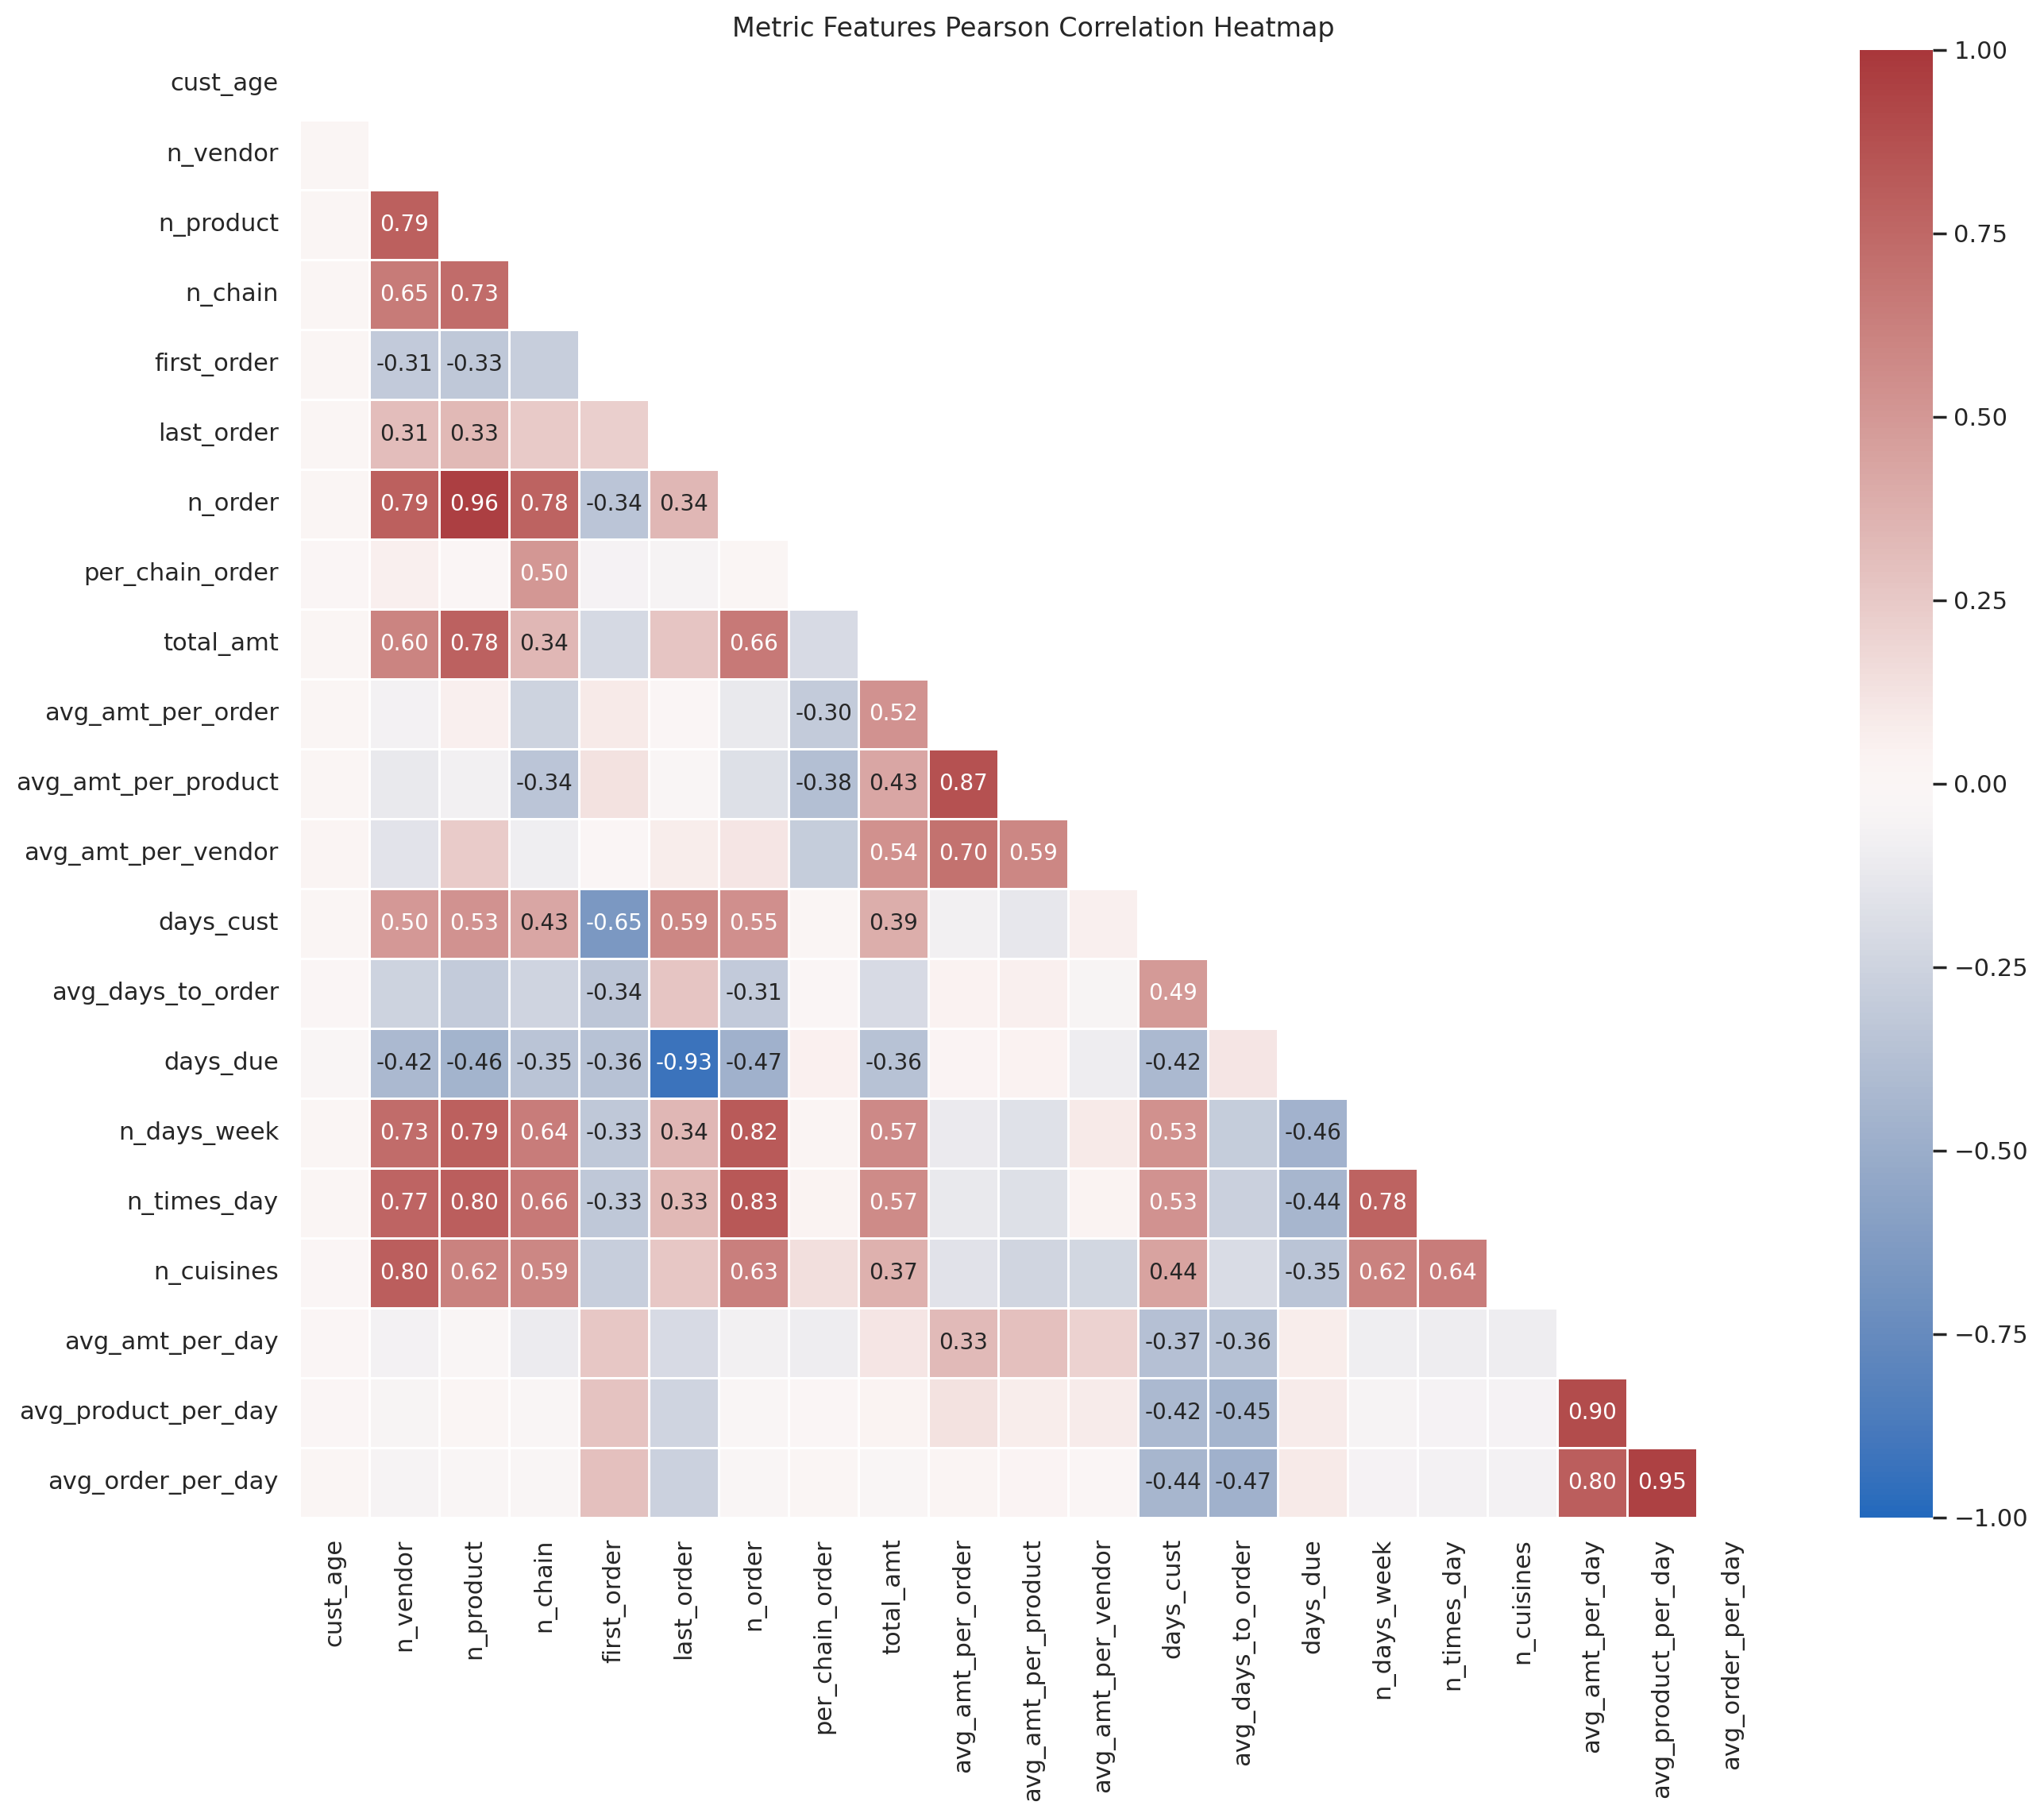

In [200]:
# compute the correlation matrix for the metric features
corr_matrix = regulars[metric_features].corr(method='pearson')

plt.figure(figsize=(15,12))

# create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

annot = np.full(corr_matrix.shape, '', dtype=object)

# Fill the annotation array with formatted values for correlations above the threshold
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        if abs(corr_matrix.iat[i, j]) >= 0.3:
            annot[i, j] = f"{corr_matrix.iat[i, j]:.2f}" 

# create the heatmap
sns.heatmap(data=corr_matrix, annot=annot, cmap='vlag', 
            fmt="", center=0, vmin=-1, vmax=1, square=True, 
            linewidths=.5, mask=mask, annot_kws={"size": 10})

# Show the plot
plt.title('Metric Features Pearson Correlation Heatmap')
plt.show()

We will perform PCA with the variables avg_amt_per_day, avg_product_per_day, avg_order_per_day, n_product and n_order - in order to reduce dimensionality and assess if the resulting principal components are of any help.

In [201]:
pca = PCA()
pca_feat = pca.fit_transform(regulars[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order']])

In [202]:
# Get the eigenvalues (explained variance)
explained_variance = pca.explained_variance_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# get the cumulative explained variance ratio 
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Combine into a dataframe
pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, pca.n_components_ + 1)
)

pca_results

,Eigenvalue,Difference,Proportion,Cumulative
1,36.701615,0.000000,0.727932,0.727932
2,12.920981,-23.780634,0.256272,0.984204
3,0.741080,-12.179901,0.014698,0.998902
4,0.051792,-0.689288,0.001027,0.999930
5,0.003547,-0.048245,0.000070,1.000000


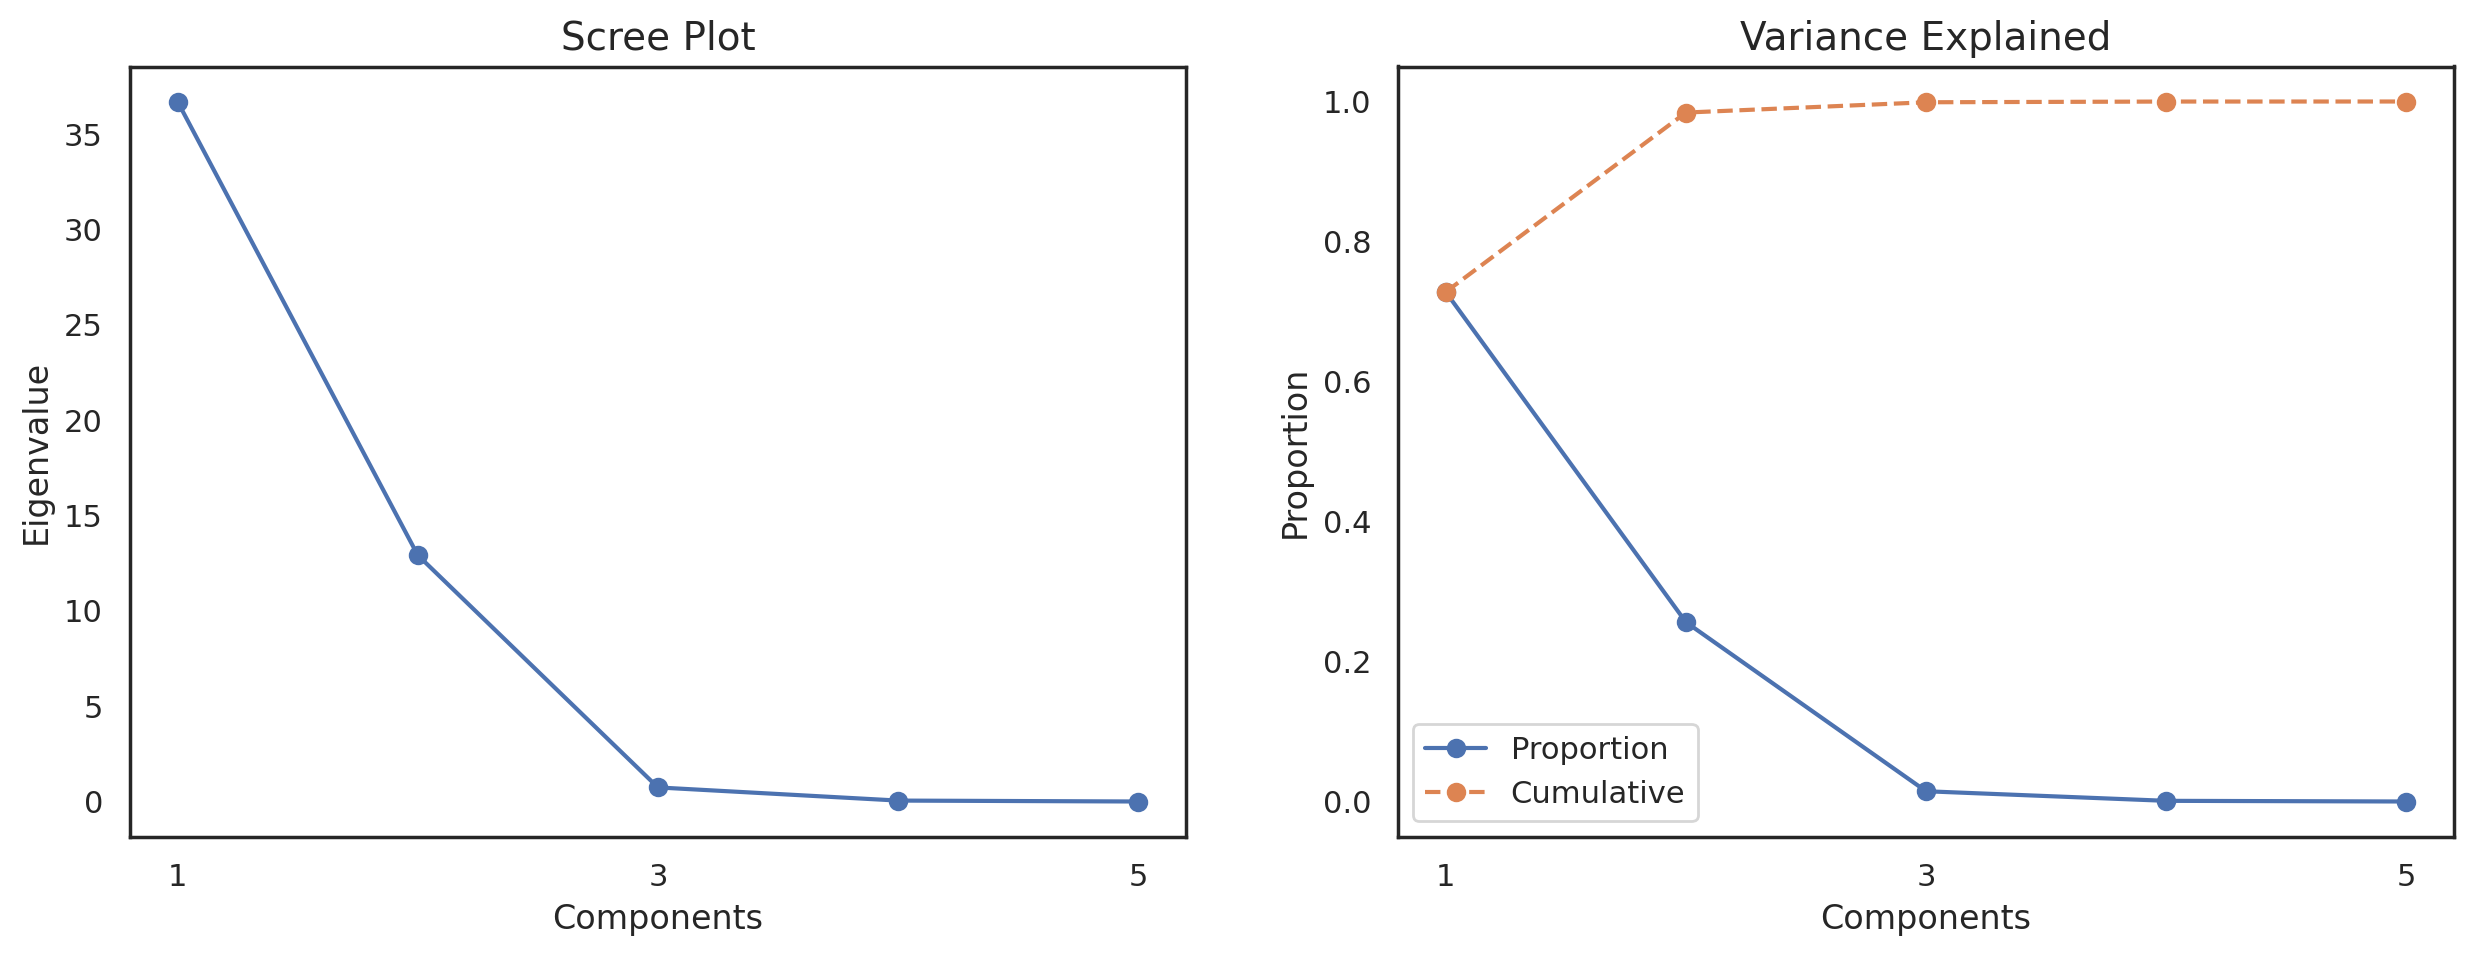

In [203]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots

ax1.plot(explained_variance, # PLOT THE EIGENVALUES (EXPLAINED VARIANCE)
         marker=".", markersize=12)

ax2.plot(explained_variance_ratio,  # PLOT THE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, label="Proportion")

ax2.plot(cumulative_explained_variance_ratio,  # PLOT THE CUMULATIVE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [204]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(regulars[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order']])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]

# remember index=df_pca.index
pca_df = pd.DataFrame(pca_feat, index=regulars.index, columns=pca_feat_names)  
pca_df.head()

,PC0,PC1,PC2
customer_id,,,
118371798366,-3.434639,27.541851,-0.281372
400089128395,-5.490217,17.496995,1.037040
1060080106083,-5.127557,7.570838,0.639973
103287041752,-4.559663,14.039621,0.243545
338018592517,-3.386898,26.087617,-0.442150


In [205]:
# Reassigning df to contain pca variables
df_pca = pd.concat([regulars, pca_df], axis=1)
df_pca.head()

,cust_age,n_vendor,n_product,n_chain,first_order,last_order,american,asian,beverages,cafe,chicken_dishes,chinese,desserts,healthy,indian,italian,japanese,noodle_dishes,other,street_food_snacks,thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,total_amt,n_order,avg_amt_per_product,avg_amt_per_order,avg_amt_per_vendor,days_cust,avg_days_to_order,days_due,per_chain_order,n_days_week,n_times_day,regular,n_cuisines,log_n_vendor,log_n_product,log_n_chain,log_american,log_asian,log_beverages,log_cafe,log_chicken_dishes,log_chinese,log_desserts,log_healthy,log_indian,log_italian,log_japanese,log_noodle_dishes,log_other,log_street_food_snacks,log_thai,log_total_amt,log_n_order,log_avg_amt_per_product,log_avg_amt_per_order,log_avg_amt_per_vendor,log_n_days_week,log_n_times_day,foodie_flag,gluttonous_flag,loyal_flag,top_cuisine,avg_amt_per_day,avg_product_per_day,avg_order_per_day,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,pay_method_CASH,pay_method_DIGI,cust_city_4.0,cust_city_8.0,PC0,PC1,PC2
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
118371798366,18,2,5,1,0,1,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,28.88,2,5.776,14.44,14.44,1,0.5,89.5,0.5,2,1,True,1,1.098612,1.791759,0.693147,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.397189,0.0,0.0,0.0,0.0,0.0,0.0,3.397189,1.098612,1.913387,2.736962,2.736962,1.098612,0.693147,0,0,0,indian,28.88,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-3.434639,27.541851,-0.281372
400089128395,17,2,2,2,0,1,12.82,6.39,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,19.21,2,9.605,9.605,9.605,1,0.5,89.5,1.0,2,2,True,2,1.098612,1.098612,1.098612,2.626117,2.000128,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.006178,1.098612,2.361326,2.361326,2.361326,1.098612,1.098612,0,0,0,american,19.21,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-5.490217,17.496995,1.037040
1060080106083,38,1,2,2,0,1,9.20,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,9.20,2,4.6,4.6,9.2,1,0.5,89.5,1.0,2,2,True,1,0.693147,1.098612,1.098612,2.322388,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.322388,1.098612,1.722767,1.722767,2.322388,1.098612,1.098612,0,0,0,american,9.2,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-5.127557,7.570838,0.639973
103287041752,27,2,3,1,0,2,0.00,13.70,0.0,0.0,0.0,0.0,0.0,0.0,17.86,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,31.56,2,10.52,15.78,15.78,2,1.0,89.0,0.5,2,2,True,2,1.098612,1.386294,0.693147,0.000000,2.687847,0.0,0.0,0.0,0.0,0.0,0.0,2.937043,0.0,0.0,0.0,0.0,0.0,0.0,3.483085,1.098612,2.444085,2.820188,2.820188,1.098612,1.098612,0,0,0,indian,15.78,1.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-4.559663,14.039621,0.243545
338018592517,20,2,5,0,0,2,14.57,40.87,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55.44,2,11.088,27.72,27.72,2,1.0,89.0,0.0,2,2,True,2,1.098612,1.791759,0.0,2.745346,3.734570,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.033178,1.098612,2.492213,3.357594,3.357594,1.098612,1.098612,0,0,0,asian,27.72,2.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-3.386898,26.087617,-0.442150


In [206]:
loadings = df_pca[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order'] + pca_feat_names].corr().loc[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order'], pca_feat_names]

In [207]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: #ffbdbd'
    elif val > 0.45:
        color = 'background-color: #b3ffcc'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings.style.map(_color_red_or_green)

,PC0,PC1,PC2
avg_amt_per_day,-0.061455,0.998037,0.009561
avg_product_per_day,-0.022121,0.898167,0.055308
avg_order_per_day,-0.046740,0.805483,0.159590
n_product,0.993720,0.041139,-0.104052
n_order,0.981966,-0.014563,0.188478


In [208]:
df_pca.drop(columns='PC2', inplace=True)

In [209]:
df_pca.rename(columns={'PC0': 'transaction_volume', 'PC1': 'interaction_rate'}, inplace=True)

In [210]:
df_pca.head()

,cust_age,n_vendor,n_product,n_chain,first_order,last_order,american,asian,beverages,cafe,chicken_dishes,chinese,desserts,healthy,indian,italian,japanese,noodle_dishes,other,street_food_snacks,thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,total_amt,n_order,avg_amt_per_product,avg_amt_per_order,avg_amt_per_vendor,days_cust,avg_days_to_order,days_due,per_chain_order,n_days_week,n_times_day,regular,n_cuisines,log_n_vendor,log_n_product,log_n_chain,log_american,log_asian,log_beverages,log_cafe,log_chicken_dishes,log_chinese,log_desserts,log_healthy,log_indian,log_italian,log_japanese,log_noodle_dishes,log_other,log_street_food_snacks,log_thai,log_total_amt,log_n_order,log_avg_amt_per_product,log_avg_amt_per_order,log_avg_amt_per_vendor,log_n_days_week,log_n_times_day,foodie_flag,gluttonous_flag,loyal_flag,top_cuisine,avg_amt_per_day,avg_product_per_day,avg_order_per_day,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,pay_method_CASH,pay_method_DIGI,cust_city_4.0,cust_city_8.0,transaction_volume,interaction_rate
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
118371798366,18,2,5,1,0,1,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,28.88,2,5.776,14.44,14.44,1,0.5,89.5,0.5,2,1,True,1,1.098612,1.791759,0.693147,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.397189,0.0,0.0,0.0,0.0,0.0,0.0,3.397189,1.098612,1.913387,2.736962,2.736962,1.098612,0.693147,0,0,0,indian,28.88,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-3.434639,27.541851
400089128395,17,2,2,2,0,1,12.82,6.39,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,19.21,2,9.605,9.605,9.605,1,0.5,89.5,1.0,2,2,True,2,1.098612,1.098612,1.098612,2.626117,2.000128,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.006178,1.098612,2.361326,2.361326,2.361326,1.098612,1.098612,0,0,0,american,19.21,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-5.490217,17.496995
1060080106083,38,1,2,2,0,1,9.20,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,9.20,2,4.6,4.6,9.2,1,0.5,89.5,1.0,2,2,True,1,0.693147,1.098612,1.098612,2.322388,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.322388,1.098612,1.722767,1.722767,2.322388,1.098612,1.098612,0,0,0,american,9.2,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-5.127557,7.570838
103287041752,27,2,3,1,0,2,0.00,13.70,0.0,0.0,0.0,0.0,0.0,0.0,17.86,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,31.56,2,10.52,15.78,15.78,2,1.0,89.0,0.5,2,2,True,2,1.098612,1.386294,0.693147,0.000000,2.687847,0.0,0.0,0.0,0.0,0.0,0.0,2.937043,0.0,0.0,0.0,0.0,0.0,0.0,3.483085,1.098612,2.444085,2.820188,2.820188,1.098612,1.098612,0,0,0,indian,15.78,1.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-4.559663,14.039621
338018592517,20,2,5,0,0,2,14.57,40.87,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55.44,2,11.088,27.72,27.72,2,1.0,89.0,0.0,2,2,True,2,1.098612,1.791759,0.0,2.745346,3.734570,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.033178,1.098612,2.492213,3.357594,3.357594,1.098612,1.098612,0,0,0,asian,27.72,2.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-3.386898,26.087617


In [211]:
regulars = df_pca

In [212]:
# regulars['log_others'] = regulars['log_cafe'] + regulars['log_other'] + regulars['log_healthy']
# regulars['log_savory'] = regulars['log_chicken_dishes'] + regulars['log_chinese'] + regulars['log_indian']
# regulars['log_fine_dining'] = regulars['log_japanese'] + regulars['log_desserts']
# regulars['log_italoamericanos'] = regulars['log_american'] + regulars['log_italian']

In [213]:
regulars['comfort_food'] = regulars['street_food_snacks'] + regulars['desserts']
regulars['japanese_drinks'] = regulars['japanese'] + regulars['beverages'] + regulars['american']
regulars['spicy'] = regulars['chicken_dishes'] + regulars['indian'] + regulars['thai']
regulars['casual_dining'] = regulars['other'] + regulars['cafe']
regulars['asian_noodles'] = regulars['chinese'] + regulars['noodle_dishes']

## 4.5. Data Normalization

For this step, we create two datasets, one using StandardScaler and another using MinMaxScaler. The clustering efforts will be applied to both and we will then choose the one which yields the best results.

In [214]:
std_scaler = StandardScaler().set_output(transform='pandas')
regulars_std = std_scaler.fit_transform(regulars.drop(columns=list(ohe_feat_names) + ['top_cuisine']))

In [215]:
minmax_scaler = MinMaxScaler().set_output(transform='pandas')
regulars_minmax = minmax_scaler.fit_transform(regulars.drop(columns=list(ohe_feat_names) + ['top_cuisine']))

## 4.6. Factor Analysis

In [216]:
fa_variables = [
    # 'american',
    'asian',
    # 'beverages',
    # 'log_others',
    # 'log_savory',
    # 'log_fine_dining',
    # 'log_italoamericanos',
    # 'cafe',
    # 'chicken_dishes',
    # 'chinese',
    # 'desserts',
    'healthy',
    # 'indian',
    'italian',
    # 'japanese',
    # 'noodle_dishes',
    # 'other',
    # 'street_food_snacks',
    # 'thai',
    # 'log_total_amt',
    # 'log_avg_amt_per_product',
    # 'log_avg_amt_per_order',
    # 'log_avg_amt_per_vendor',
    # 'transaction_volume',
    # 'interaction_rate'
    'comfort_food',
    'japanese_drinks',
    'spicy',
    'casual_dining',
    'asian_noodles'
]

fa_data = regulars_std[fa_variables]

### a) Data Suitability Tests

In [217]:
# Perform KMO and Bartlett's Test
kmo_all, kmo_model = calculate_kmo(fa_data)
chi_square_value, p_value = calculate_bartlett_sphericity(fa_data)

print(f"KMO: {kmo_model}")  # A value closer to 1 is better (>=0.60 is acceptable)
print(f"Bartlett's p-value: {p_value}")  # p-value should be < 0.05 for factor analysis to be appropriate

KMO: 0.5984778615762266
Bartlett's p-value: 0.0


### b) Perform Factor Analysis

In [218]:
# n_factors = [2, 5]
# rotations = ['promax', 'oblimin', 'quartimin'] # Oblique rotations assume correlation between the features.

In [219]:
fa = FactorAnalyzer(method='ml', n_factors=4, rotation='oblimin')  # You can adjust n_factors based on your choice
fa.fit(fa_data)

FactorAnalyzer(method='ml', n_factors=4, rotation='oblimin', rotation_kwargs={})

### c) Solution Suitability Assessment

In [220]:
# Check the factor sufficiency score
sufficiency_score = fa.sufficiency(fa_data.shape[0])

print(f"Factor Sufficiency: \n {list(zip(['statistic', 'degrees', 'pvalue'], sufficiency_score))}")  # p-value < .1

Factor Sufficiency: 
 [('statistic', 28.57468440333155), ('degrees', 2), ('pvalue', 6.238585345906448e-07)]


In [221]:
# Check Eigenvalues and Plot Scree
eigenvalues, values = fa.get_eigenvalues() 
print("Eigenvalues:", eigenvalues) # Select number of factors for eigenvalue above 1.

Eigenvalues: [1.46112172 1.10810959 1.0196485  0.9704129  0.94452538 0.87920331
 0.82321666 0.79376194]


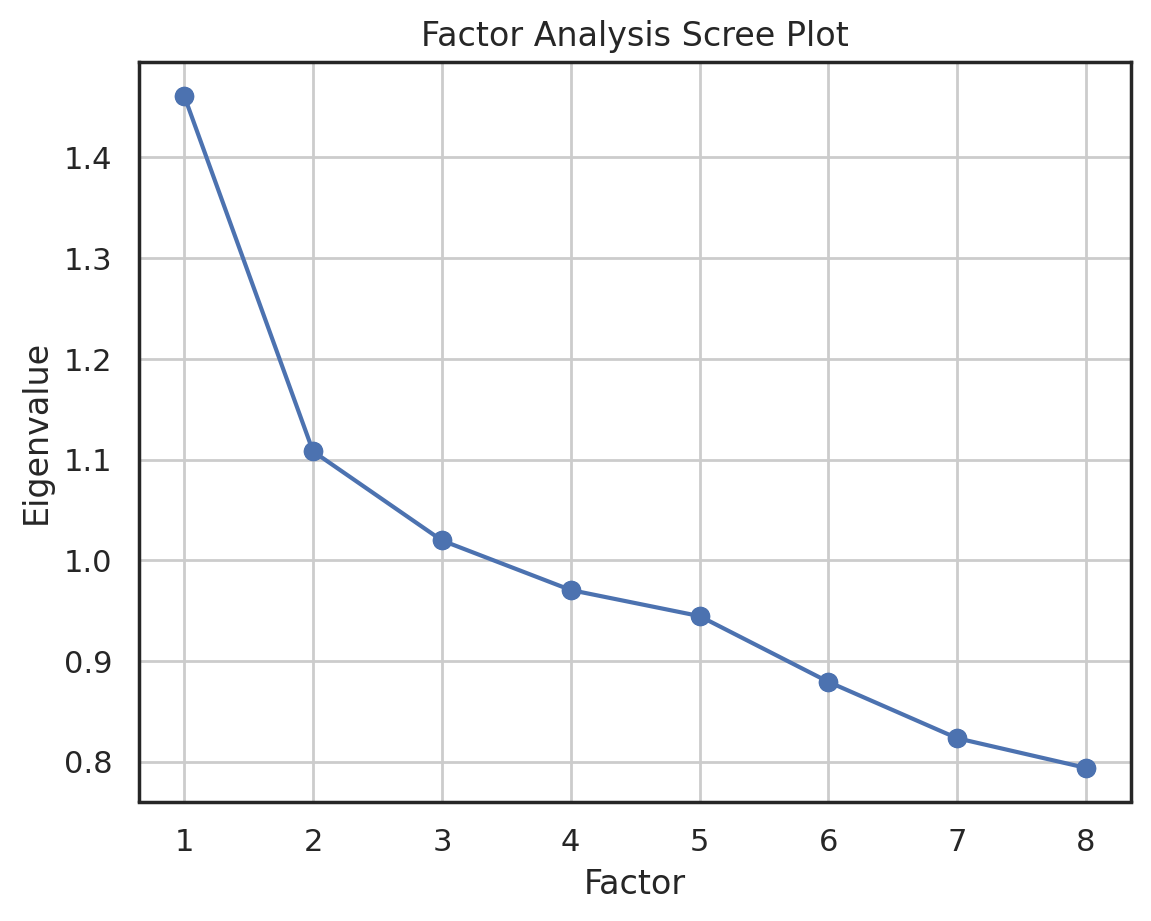

In [222]:
xvals = range(1, fa_data.shape[1] + 1)

plt.scatter(xvals, eigenvalues)
plt.plot(xvals, eigenvalues, # PLOT THE EIGENVALUES (EXPLAINED VARIANCE)
         marker=".", markersize=12)

plt.title('Factor Analysis Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')

plt.grid()
plt.show()

In [223]:
# Analyze Factor Loadings
loadings = fa.loadings_

display(pd.DataFrame.from_records(loadings, index=fa_data.columns))

,0,1,2,3
asian,-0.005070,0.003700,0.514124,0.010927
healthy,-0.019300,-0.026119,0.054583,0.124917
italian,0.997495,-0.000002,-0.000129,-0.000133
comfort_food,-0.012692,-0.010678,0.361076,-0.047980
japanese_drinks,0.039973,-0.022989,0.258712,0.074982
spicy,-0.021972,-0.028332,-0.225305,0.086878
casual_dining,0.000305,0.001195,-0.001640,0.627315
asian_noodles,0.000001,0.997492,0.000018,0.000191


In [224]:
# Check Communalities and Uniquenesses
communalities = fa.get_communalities()
print("Communalities:")
print(communalities) # Look for high communalities (typically > 0.50)

uniqueness = fa.get_uniquenesses()
print("Uniqueness:")
print(uniqueness) # Look for low-values (typically < 0.5)

Communalities:
[0.26448232 0.0196383  0.99499654 0.13295284 0.07468074 0.0595959
 0.39352832 0.99499005]
Uniqueness:
[0.73551768 0.9803617  0.00500346 0.86704716 0.92531926 0.9404041
 0.60647168 0.00500995]


In [225]:
factor_var = fa.get_factor_variance()
print("Factor Variance:")
print(factor_var) # Look for high communalities (typically > 0.50)

Factor Variance:
(array([0.99763647, 0.99713253, 0.51537586, 0.42472015]), array([0.12470456, 0.12464157, 0.06442198, 0.05309002]), array([0.12470456, 0.24934612, 0.31376811, 0.36685813]))


In [226]:
factor_scores = np.dot(fa_data, loadings)

In [227]:
factor_scores_df = pd.DataFrame(factor_scores, columns=['italian_dining', 'asian_noodles_dining', 'asian_spicy_comfort', 'causal_healthy']).set_index(regulars_std.index)

In [228]:
factor_scores_df.head()

,italian_dining,asian_noodles_dining,asian_spicy_comfort,causal_healthy
customer_id,,,,
118371798366,-0.417287,-0.364099,-1.256456,-0.026077
400089128395,-0.309948,-0.280842,-0.116998,-0.271739
1060080106083,-0.317328,-0.276815,-0.315859,-0.291227
103287041752,-0.390662,-0.323704,-0.648136,-0.136753
338018592517,-0.313261,-0.277767,0.676877,-0.247488


In [229]:
regulars_std = pd.concat([regulars_std, factor_scores_df], axis=1)

In [230]:
regulars_std.head()

,cust_age,n_vendor,n_product,n_chain,first_order,last_order,american,asian,beverages,cafe,chicken_dishes,chinese,desserts,healthy,indian,italian,japanese,noodle_dishes,other,street_food_snacks,thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,total_amt,n_order,avg_amt_per_product,avg_amt_per_order,avg_amt_per_vendor,days_cust,avg_days_to_order,days_due,per_chain_order,n_days_week,n_times_day,regular,n_cuisines,log_n_vendor,log_n_product,log_n_chain,log_american,log_asian,log_beverages,log_cafe,log_chicken_dishes,log_chinese,log_desserts,log_healthy,log_indian,log_italian,log_japanese,log_noodle_dishes,log_other,log_street_food_snacks,log_thai,log_total_amt,log_n_order,log_avg_amt_per_product,log_avg_amt_per_order,log_avg_amt_per_vendor,log_n_days_week,log_n_times_day,foodie_flag,gluttonous_flag,loyal_flag,avg_amt_per_day,avg_product_per_day,avg_order_per_day,transaction_volume,interaction_rate,comfort_food,japanese_drinks,spicy,casual_dining,asian_noodles,italian_dining,asian_noodles_dining,asian_spicy_comfort,causal_healthy
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
118371798366,-1.346725,-0.650712,-0.209132,-0.667565,-1.149905,-3.468556,-0.482232,-0.486713,-0.312392,-0.158327,-0.256896,-0.246269,-0.200376,-0.205023,4.142561,-0.332425,-0.353916,-0.187189,-0.356067,-0.277053,-0.228534,0.443328,-0.659766,-0.67998,-0.690926,-0.745976,-0.715692,0.22124,-0.173238,-0.188494,-0.200239,-0.259281,-0.25772,-0.248797,-0.231544,-0.243772,-0.277348,-0.365201,-0.430013,-0.470727,-0.434801,-0.414285,-0.403718,-0.427649,-0.460111,-0.465998,2.001594,-0.361611,-0.289779,-0.223538,-0.180459,-0.179915,-0.311562,-0.7411,-0.362090,0.840418,0.134625,-1.742395,-1.461799,3.011553,-0.370952,-0.774842,-1.258787,0.0,-1.231481,-0.687695,0.025828,-0.708182,-0.724921,-0.774900,-0.44581,-0.206229,-0.328668,-0.342946,-0.253677,-0.268908,3.871515,-0.49452,-0.498108,-0.258362,-0.523848,-0.387196,-0.279027,-0.023260,-1.028303,-0.154853,1.020374,0.484381,-0.769218,-1.812370,-0.305365,-0.099981,-0.087284,7.619382,12.441459,6.361429,-0.566954,7.662220,-0.312949,-0.671234,3.146957,-0.371781,-0.29757,-0.417287,-0.364099,-1.256456,-0.026077
400089128395,-1.488091,-0.650712,-0.821671,-0.333804,-1.149905,-3.468556,0.645938,-0.210450,-0.312392,-0.158327,-0.256896,-0.246269,-0.200376,-0.205023,-0.245846,-0.332425,-0.353916,-0.187189,-0.356067,-0.277053,-0.228534,0.443328,-0.659766,-0.67998,-0.690926,-0.745976,-0.715692,0.22124,-0.173238,-0.188494,-0.200239,-0.259281,-0.25772,-0.248797,-0.231544,-0.243772,-0.277348,-0.365201,0.784257,0.707817,-0.434801,-0.414285,-0.403718,-0.427649,-0.460111,-0.465998,-0.432432,-0.361611,-0.289779,-0.223538,-0.180459,-0.179915,-0.563798,-0.7411,0.791321,0.058946,-0.319348,-1.742395,-1.461799,3.011553,1.037586,-0.774842,-0.709372,0.0,-0.407624,-0.687695,-1.228530,-0.098948,1.351734,0.509934,-0.44581,-0.206229,-0.328668,-0.342946,-0.253677,-0.268908,-0.337019,-0.49452,-0.498108,-0.258362,-0.523848,-0.387196,-0.279027,-0.518125,-1.028303,0.847672,0.343304,-0.101944,-0.769218,-0.743351,-0.305365,-0.099981,-0.087284,4.911764,4.624477,6.361429,-0.906267,4.867713,-0.312949,0.106654,-0.386799,-0.371781,-0.29757,-0.309948,-0.280842,-0.116998,-0.271739
1060080106083,1.480597,-1.115334,-0.821671,-0.333804,-1.149905,-3.468556,0.327375,-0.486713,-0.312392,-0.158327,-0.256896,-0.246269,-0.200376,-0.205023,-0.245846,-0.332425,-0.353916,-0.187189,-0.356067,-0.277053,-0.228534,0.443328,-0.659766,-0.67998,-0.690926,-0.745976,-0.715692,0.22124,-0.173238,-0.188494,-0.200239,-0.259281,-0.25772,-0.248797,-0.231544,-0.243772,-0.277348,1.087580,-0.430013,0.707817,-0.434801,-0.414285,-0.403718,-0.427649,-0.460111,-0.465998,-0.432432,-0.361611,-0.289779,-0.223538,-0.180459,-0.179915,-0.824903,-0.7411,-0.716336,-0.750003,-0.357375,-1.742395,-1.461799,3.011553,1.

In [231]:
drop_feats = [
    'american'
    ,'beverages'
    ,'cafe'
    ,'chicken_dishes'
    ,'chinese'
    ,'desserts'
    ,'indian'
    ,'japanese'
    ,'noodle_dishes'
    ,'other'
    ,'street_food_snacks'
    ,'thai'
    ,'comfort_food'
    ,'japanese_drinks'
    ,'spicy'
    ,'casual_dining'
    ,'asian_noodles'
]

In [232]:
regulars_std.drop(columns=drop_feats, inplace=True)

In [233]:
regulars_std.head()

,cust_age,n_vendor,n_product,n_chain,first_order,last_order,asian,healthy,italian,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,total_amt,n_order,avg_amt_per_product,avg_amt_per_order,avg_amt_per_vendor,days_cust,avg_days_to_order,days_due,per_chain_order,n_days_week,n_times_day,regular,n_cuisines,log_n_vendor,log_n_product,log_n_chain,log_american,log_asian,log_beverages,log_cafe,log_chicken_dishes,log_chinese,log_desserts,log_healthy,log_indian,log_italian,log_japanese,log_noodle_dishes,log_other,log_street_food_snacks,log_thai,log_total_amt,log_n_order,log_avg_amt_per_product,log_avg_amt_per_order,log_avg_amt_per_vendor,log_n_days_week,log_n_times_day,foodie_flag,gluttonous_flag,loyal_flag,avg_amt_per_day,avg_product_per_day,avg_order_per_day,transaction_volume,interaction_rate,italian_dining,asian_noodles_dining,asian_spicy_comfort,causal_healthy
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
118371798366,-1.346725,-0.650712,-0.209132,-0.667565,-1.149905,-3.468556,-0.486713,-0.205023,-0.332425,0.443328,-0.659766,-0.67998,-0.690926,-0.745976,-0.715692,0.22124,-0.173238,-0.188494,-0.200239,-0.259281,-0.25772,-0.248797,-0.231544,-0.243772,-0.277348,-0.365201,-0.430013,-0.470727,-0.434801,-0.414285,-0.403718,-0.427649,-0.460111,-0.465998,2.001594,-0.361611,-0.289779,-0.223538,-0.180459,-0.179915,-0.311562,-0.7411,-0.362090,0.840418,0.134625,-1.742395,-1.461799,3.011553,-0.370952,-0.774842,-1.258787,0.0,-1.231481,-0.687695,0.025828,-0.708182,-0.724921,-0.774900,-0.44581,-0.206229,-0.328668,-0.342946,-0.253677,-0.268908,3.871515,-0.49452,-0.498108,-0.258362,-0.523848,-0.387196,-0.279027,-0.023260,-1.028303,-0.154853,1.020374,0.484381,-0.769218,-1.812370,-0.305365,-0.099981,-0.087284,7.619382,12.441459,6.361429,-0.566954,7.662220,-0.417287,-0.364099,-1.256456,-0.026077
400089128395,-1.488091,-0.650712,-0.821671,-0.333804,-1.149905,-3.468556,-0.210450,-0.205023,-0.332425,0.443328,-0.659766,-0.67998,-0.690926,-0.745976,-0.715692,0.22124,-0.173238,-0.188494,-0.200239,-0.259281,-0.25772,-0.248797,-0.231544,-0.243772,-0.277348,-0.365201,0.784257,0.707817,-0.434801,-0.414285,-0.403718,-0.427649,-0.460111,-0.465998,-0.432432,-0.361611,-0.289779,-0.223538,-0.180459,-0.179915,-0.563798,-0.7411,0.791321,0.058946,-0.319348,-1.742395,-1.461799,3.011553,1.037586,-0.774842,-0.709372,0.0,-0.407624,-0.687695,-1.228530,-0.098948,1.351734,0.509934,-0.44581,-0.206229,-0.328668,-0.342946,-0.253677,-0.268908,-0.337019,-0.49452,-0.498108,-0.258362,-0.523848,-0.387196,-0.279027,-0.518125,-1.028303,0.847672,0.343304,-0.101944,-0.769218,-0.743351,-0.305365,-0.099981,-0.087284,4.911764,4.624477,6.361429,-0.906267,4.867713,-0.309948,-0.280842,-0.116998,-0.271739
1060080106083,1.480597,-1.115334,-0.821671,-0.333804,-1.149905,-3.468556,-0.486713,-0.205023,-0.332425,0.443328,-0.659766,-0.67998,-0.690926,-0.745976,-0.715692,0.22124,-0.173238,-0.188494,-0.200239,-0.259281,-0.25772,-0.248797,-0.231544,-0.243772,-0.277348,1.087580,-0.430013,0.707817,-0.434801,-0.414285,-0.403718,-0.427649,-0.460111,-0.465998,-0.432432,-0.361611,-0.289779,-0.223538,-0.180459,-0.179915,-0.824903,-0.7411,-0.716336,-0.750003,-0.357375,-1.742395,-1.461799,3.011553,1.037586,-0.774842,-0.709372,0.0,-1.231481,-1.655109,-1.228530,-0.098948,1.111554,-0.774900,-0.44581,-0.206229,-0.328668,-0.342946,-0.253677,-0.268908,-0.337019,-0.49452,-0.498108,-0.258362,-0.523848,-0.387196,-0.279027,-1.383530,-1.028303,-0.581477,-0.807674,-0.162722,-0.769218,-0.743351,-0.305365,-0.099981,-0.087284,2.108945,4.624477,6.361429,-0.846403,2.106228,-0.317328,-0.276815,-0.315859,-0.291227
103287041752,-0.074430,-0.650712,-0.617491,-0.667565,-1.149905,-3.417019,0.105589,-0.205023,-0.332425,-0.656675,0.428152,-0.67998,-0.690926,-0.745976,-0.715692,0.22124,-0.173238,-0.188494,-0.200239,-0.259281,-0.25772,-0.248797,-0.231544,-0.24377

# 5. Clustering

## 5.1. K-Means with Hierarchical Centroid Initialization

In [234]:
# Function to calculate R² for a clustering solution
def get_rsq(df, features, label_column):
    """Calculates R² for a clustering solution.
    
    R² = SSb / SSt
    where:
    SSb = between-group sum of squares
    SSt = total sum of squares
    
    Parameters:
    df (DataFrame): The dataframe containing the features and cluster labels
    features (list): List of feature columns to consider
    label_column (str): The column containing the cluster labels
    
    Returns:
    float: R² value indicating homogeneity of the clusters
    """
    # Total Sum of Squares (SSt)
    mean = df[features].mean().values
    sst = np.sum((df[features] - mean) ** 2)

    # Between-group Sum of Squares (SSb)
    ssb = 0
    for label in df[label_column].unique():
        group = df[df[label_column] == label]
        group_mean = group[features].mean().values
        ssb += len(group) * np.sum((group_mean - mean) ** 2)
        
    # R² Calculation
    r2 = ssb / sst if sst != 0 else 0
    return r2

In [237]:
# Running R² Calculation for Different Hierarchical Clustering Methods
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

# Initialize an empty list to store R² values for each method
r2_hc = []

# Compute R² for each clustering method and range of clusters
for link in hc_methods:
    r2_method = []
    for i in range(1, max_nclus + 1):  # Loop over cluster counts
        cluster = AgglomerativeClustering(n_clusters=i, metric="euclidean", linkage=link)
        
        # Get cluster labels
        hclabels = cluster.fit_predict(regulars_std) 
        
        # Concatenate the df with the cluster labels
        df_concat = pd.concat([regulars_std, pd.Series(hclabels, name='labels', index=regulars_std.index)], axis=1)  
        
        # Compute R² for the current number of clusters
        r2_method.append(get_rsq(df_concat, regulars_std.columns.tolist(), 'labels'))
    
    r2_hc.append(r2_method)

# Convert R² results into a numpy array for easier manipulation
r2_hc = np.vstack(r2_hc)

/home/shadybea/anaconda3/envs/dm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# Plotting the R² values for Hierarchical Clustering Methods
sns.set()

# Create a figure for the plot
fig = plt.figure(figsize=(11, 5))

# Plot the R² values for each clustering method
for i, link in enumerate(hc_methods):
    sns.lineplot(data=r2_hc[i], linewidth=2.5, markers=["o"] * max_nclus, label=link)

# Finalize the plot
plt.legend(title="HC Methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of Clusters", fontsize=13)
plt.ylabel("R² Metric", fontsize=13)
fig.suptitle("$R^2$ Plot for Various Hierarchical Methods", fontsize=21)

plt.show()

In [ ]:
# Plotting the Dendrogram for Hierarchical Clustering
# Using the 'ward' method for dendrogram plotting (you can adjust this method)
linkage_matrix = linkage(regulars_std.values, method="ward", metric="euclidean")

sns.set()
fig = plt.figure(figsize=(11, 5))
# Set a threshold for cutting the dendrogram
y_threshold = 5
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21)
plt.xlabel('Number of Points in Node')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [ ]:
n_clusters = 4  # Example number of clusters chosen

# Get the labels from hierarchical chosen clustering solution
cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward") # Example params
hc_labels = cluster.fit_predict(df)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(n_clusters):
    cluster_points = df[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)

centroids = np.array(centroids)


In [ ]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1)  # n_init=1 since we are providing initial centroids
kmeans.fit(df)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(df, kmeans_labels)
print(f"Silhouette Score: {silhouette_avg}")

In [ ]:
# KMeans cluster labels
kmeans_labels = kmeans.labels_

# KMeans centroids after fitting
kmeans_centroids = kmeans.cluster_centers_
print("KMeans Centroids:")
print(kmeans_centroids)